In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gnn_boundary.datasets import *
from gnn_boundary.models import *
from gnn_boundary.utils import *
from gnn_boundary.criteria import *
from gnn_boundary.regularizations import *
from gnn_boundary import Trainer, Evaluator, GraphSampler

In [3]:
import shelve
import torch
import numpy as np

# ENZYMES

In [4]:
dataset = ENZYMESDataset(seed=12345)

In [5]:
model = GCNClassifier(node_features=len(dataset.NODE_CLS),
                      num_classes=len(dataset.GRAPH_CLS),
                      hidden_channels=32,
                      num_layers=3)
model.load_state_dict(torch.load('ckpts/enzymes.pt'))

<All keys matched successfully>

In [6]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)

/opt/homebrew/Caskroom/mambaforge/base/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/homebrew/Caskroom/mambaforge/base/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
evaluation = dataset.model_evaluate(model)
evaluation

{'acc': 0.7166666388511658,
 'cm': array([[70,  4,  3, 11,  4,  8],
        [ 6, 72,  6,  7,  4,  5],
        [ 5,  8, 77,  4,  3,  3],
        [ 7,  5,  0, 80,  2,  6],
        [ 9,  8,  6,  3, 65,  9],
        [ 6, 11,  6,  6,  5, 66]]),
 'f1': {'EC1': 0.6896551847457886,
  'EC2': 0.692307710647583,
  'EC3': 0.7777777910232544,
  'EC4': 0.758293867111206,
  'EC5': 0.7103825211524963,
  'EC6': 0.6700507402420044}}

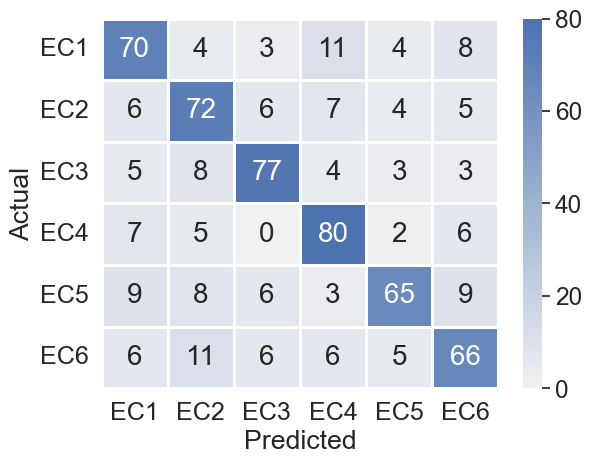

In [8]:
draw_matrix(evaluation['cm'], dataset.GRAPH_CLS.values(), fmt='d')

In [9]:
mean_embeds = [d.model_transform(model, key="embeds").mean(dim=0) for d in dataset_list_gt]

/opt/homebrew/Caskroom/mambaforge/base/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


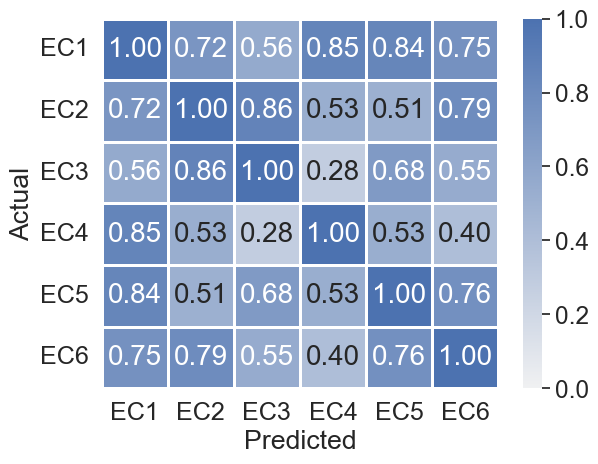

In [10]:
adj_ratio_mat, boundary_info = pairwise_boundary_analysis(model, dataset_list_pred)
draw_matrix(adj_ratio_mat, names=dataset.GRAPH_CLS.values(), fmt='.2f')

In [11]:
trainer = {}
sampler = {}

# 0 & 1

In [12]:
cls_1, cls_2 = 0, 3
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=1
        ), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [13]:
trainer[0, 3].train(
    iterations=2000,
    target_probs={cls_1: (0.3, 0.7), cls_2: (0.3, 0.7)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=21 m=29
logits=[-16.82131576538086, -17.630754470825195, -18.855365753173828, -16.57048225402832, -19.673187255859375, -17.789461135864258]
probs=[0.3031652271747589, 0.1349412053823471, 0.03965543210506439, 0.38959643244743347, 0.01750359684228897, 0.11513812839984894]


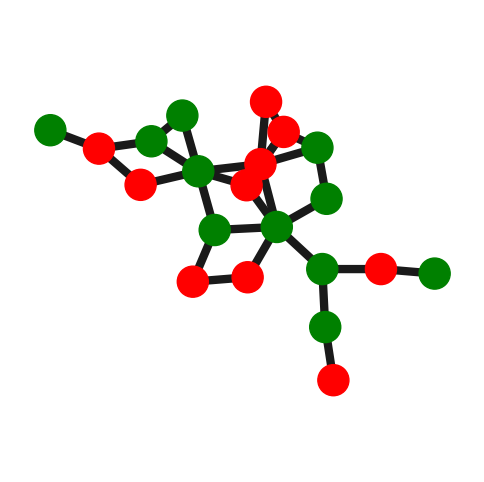

In [14]:
trainer[0, 3].evaluate(threshold=0.5, show=True)

# 0 & 3

In [42]:
cls_1, cls_2 = 0, 3
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=1
        ), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [43]:
trainer[0, 3].train(
    iterations=2000,
    target_probs={cls_1: (0.3, 0.7), cls_2: (0.3, 0.7)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=23 m=35
logits=[-16.574073791503906, -18.986387252807617, -18.06410026550293, -17.0703182220459, -19.88121795654297, -18.74933433532715]
probs=[0.4821632206439972, 0.043205562978982925, 0.10866352170705795, 0.2935471534729004, 0.01765710860490799, 0.05476340278983116]


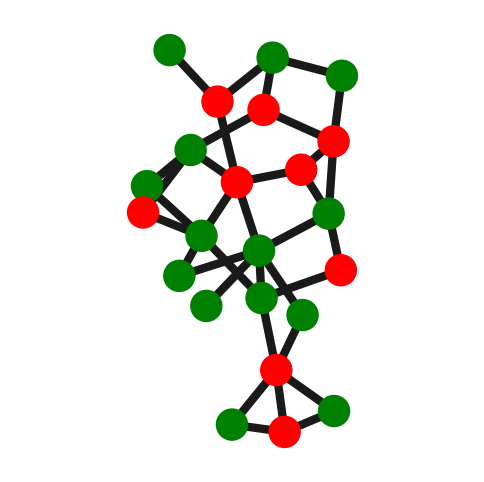

In [44]:
trainer[0, 3].evaluate(threshold=0.5, show=True)

# 0 & 4

In [28]:
cls_1, cls_2 = 0, 4
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=1
        ), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [31]:
trainer[0, 4].train(
    iterations=2000,
    target_probs={cls_1: (0.3, 0.7), cls_2: (0.3, 0.7)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  9%|8         | 196/2196 [00:00<?, ?it/s]

True

n=20 m=26
logits=[-23.88468360900879, -44.10559844970703, -35.69553756713867, -24.99376678466797, -24.683483123779297, -26.38208770751953]
probs=[0.5370466113090515, 8.875242762940161e-10, 3.986789124610368e-06, 0.1771508753299713, 0.24160046875476837, 0.04419805482029915]


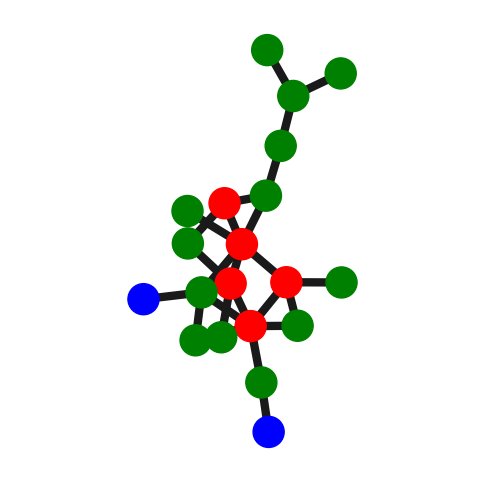

In [32]:
trainer[0, 4].evaluate(threshold=0.5, show=True)

# 0 & 5

In [33]:
cls_1, cls_2 = 0, 5
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=1
        ), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [34]:
trainer[0, 5].train(
    iterations=2000,
    target_probs={cls_1: (0.3, 0.7), cls_2: (0.3, 0.7)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=24 m=36
logits=[-22.32322120666504, -33.17026901245117, -28.111858367919922, -25.23469352722168, -23.205978393554688, -21.936532974243164]
probs=[0.33976444602012634, 6.612488050450338e-06, 0.0010404104832559824, 0.01848168484866619, 0.1405404508113861, 0.5001663565635681]


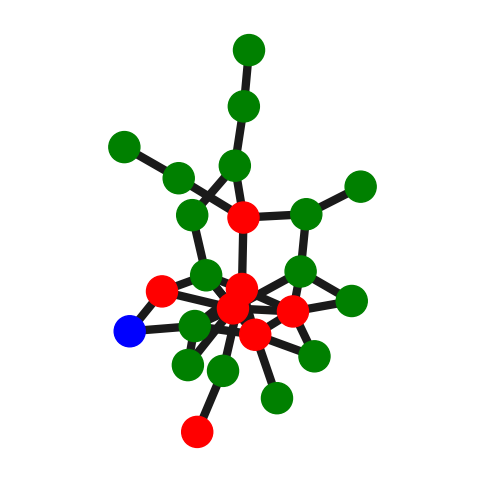

In [35]:
trainer[0, 5].evaluate(threshold=0.5, show=True)

# 1 & 2

In [36]:
cls_1, cls_2 = 1, 2
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=1
        ), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [37]:
trainer[1, 2].train(
    iterations=2000,
    target_probs={cls_1: (0.3, 0.7), cls_2: (0.3, 0.7)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=19 m=28
logits=[-18.712879180908203, -17.219934463500977, -17.27124786376953, -18.61494255065918, -19.846986770629883, -21.556886672973633]
probs=[0.08960122615098953, 0.3987416625022888, 0.3787969648838043, 0.09882055968046188, 0.028825528919696808, 0.005214074160903692]


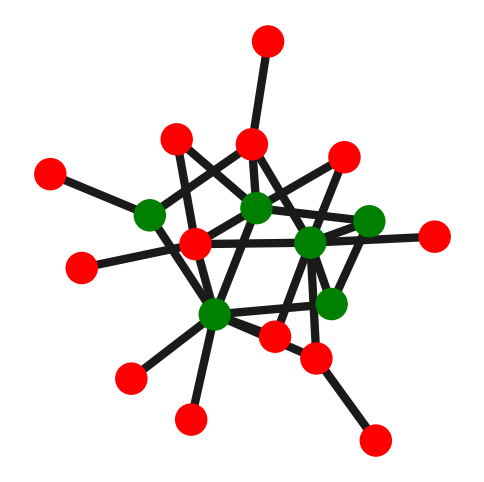

In [38]:
trainer[1, 2].evaluate(threshold=0.5, show=True)

# 1 & 5

In [39]:
cls_1, cls_2 = 1, 5
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=1
        ), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [40]:
trainer[1, 5].train(
    iterations=2000,
    target_probs={cls_1: (0.3, 0.7), cls_2: (0.3, 0.7)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=19 m=20
logits=[-15.495075225830078, -14.206451416015625, -15.27230167388916, -17.455400466918945, -16.55912971496582, -14.548768997192383]
probs=[0.11186468601226807, 0.40582165122032166, 0.13977912068367004, 0.01575195975601673, 0.038599349558353424, 0.28818315267562866]


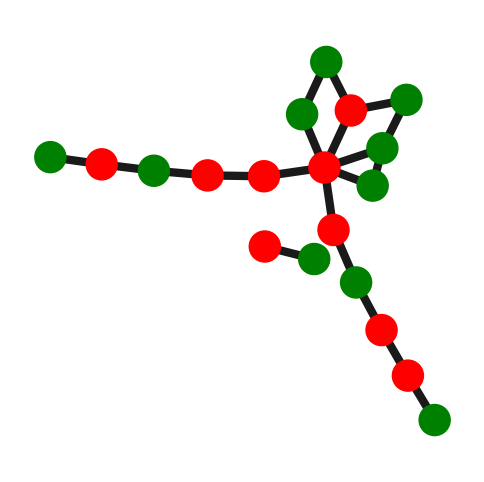

In [41]:
trainer[1, 5].evaluate(threshold=0.5, show=True)

# 4 & 5

In [45]:
cls_1, cls_2 = 4, 5
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=1
        ), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [46]:
trainer[4, 5].train(
    iterations=2000,
    target_probs={cls_1: (0.3, 0.7), cls_2: (0.3, 0.7)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=15 m=18
logits=[-20.2861270904541, -31.259082794189453, -29.636241912841797, -23.992536544799805, -16.948116302490234, -16.982791900634766]
probs=[0.017733346670866013, 3.042962646304659e-07, 1.5420108638863894e-06, 0.0004356297431513667, 0.49942511320114136, 0.48240405321121216]


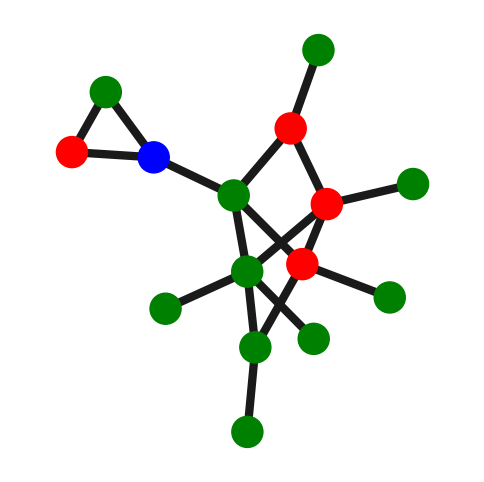

In [47]:
trainer[4, 5].evaluate(threshold=0.5, show=True)